In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = pd.read_pickle('./IntermediatePickles/model_df.pkl')

In [2]:
cutoff = datetime.strptime('2014-03-01','%Y-%m-%d')


In [3]:
final_GDP = df.GDP_interp.loc[df.chart_date==cutoff].values[0]
first_GDP = df.GDP_interp.values[0]
print(final_GDP,first_GDP)

52642.28888888889 17381.652173913044


In [4]:

df['GDP_interp'] = df.GDP_interp.diff()
df['sentiment'] = df.sentiment.diff()

In [5]:
df.dropna(inplace=True)
df = df[:-4]

In [6]:
X = df.sentiment
y = df.GDP_interp
test_df = df.loc[df.chart_date > cutoff]
train_df = df.loc[df.chart_date <= cutoff]
X_train = train_df.sentiment
X_test = test_df.sentiment
y_train = train_df.GDP_interp
y_test = test_df.GDP_interp

In [7]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline

In [8]:
def shuffle(window,data):
    res = []
    for i,v in enumerate(data[:-window]):
        for n in range(window):
            res.append(data[i+n])
    shuffle_len = int(len(res)/window)
    res = np.array(res).reshape((shuffle_len,window,1))
    return(res)

In [9]:
window = 24
X_train = shuffle(window=window,data=X_train)
X_test = shuffle(window=window,data=X_test)
y_train = shuffle(window=window,data=y_train)
y_test = shuffle(window=window,data=y_test)

In [10]:
print(y_train.shape)

(642, 24, 1)


In [11]:
y_train = y_train.reshape(X_train.shape[0], -1)
y_test = y_test.reshape(X_train.shape[0], -1)

ValueError: cannot reshape array of size 1824 into shape (642,newaxis)

In [34]:
def create_model(n_neurons=50, optimizer='adam',loss = 'mean_squared_error'):
    model = Sequential()
    model.add(layers.LSTM(
        n_neurons, input_shape = (24,1), recurrent_activation='tanh', activation='relu', return_sequences = True))
    model.add(layers.LSTM(
        n_neurons, input_shape = (24,1), recurrent_activation='tanh', activation='relu', return_sequences = False))
    model.add(layers.Dense(n_neurons))
    model.add(layers.Dense(1))
    model.compile(loss=loss, optimizer= optimizer)
    return(model)

In [35]:
lstm = KerasRegressor(build_fn=create_model,verbose=1)
standscale = StandardScaler()

pipeline = Pipeline([
    #('standscale',standscale),
    ('lstm', lstm)
])


In [36]:

model_fit = pipeline.fit(
    X_train,
    y_train,
    lstm__epochs=50,
    )

Epoch 1/50


c:\Users\kapta\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 9ms/step - loss: 11019.8193
Epoch 2/50
21/21 [==============================] - 0s 9ms/step - loss: 10990.0957
Epoch 3/50
21/21 [==============================] - 0s 9ms/step - loss: 10952.6758
Epoch 4/50
21/21 [==============================] - 0s 11ms/step - loss: 10907.7246
Epoch 5/50
21/21 [==============================] - 0s 10ms/step - loss: 10853.7090
Epoch 6/50
21/21 [==============================] - 0s 9ms/step - loss: 10790.9287
Epoch 7/50
21/21 [==============================] - 0s 9ms/step - loss: 10715.4766
Epoch 8/50
21/21 [==============================] - 0s 10ms/step - loss: 10569.5479
Epoch 9/50
21/21 [==============================] - 0s 9ms/step - loss: 10258.9141
Epoch 10/50
21/21 [==============================] - 0s 9ms/step - loss: 10348.7119
Epoch 11/50
21/21 [==============================] - 0s 9ms/step - loss: 10209.3213
Epoch 12/50
21/21 [==============================] - 0s 9ms/step - loss: 8681.5371
Epoch 13/5

In [38]:
X_train.shape

(642, 24, 1)

In [37]:
y_pred_train = model_fit.predict(X_train)
y_pred_train.shape

21/21 [==============================] - 0s 3ms/step


ValueError: cannot reshape array of size 642 into shape (24)

In [ ]:
y_pred_train[0]

array([32.10617 , 45.23111 , 57.07578 , 57.937557, 49.8739  , 48.60626 ,
       51.109173, 52.58878 , 52.89099 , 52.28649 , 53.644337, 52.790672,
       48.99792 , 47.356018, 50.35073 , 59.093243, 58.19151 , 47.09342 ,
       39.447746, 41.300964, 53.847237, 64.48417 , 58.78519 , 40.13469 ],
      dtype=float32)

In [30]:
y_train[0]

array([ 104.34782609,   87.27173913,   84.45652174,   87.27173913,
        113.66666667,  102.66666667,  113.66666667,  -21.0989011 ,
        -21.8021978 ,  -21.0989011 ,   -9.43478261,   -9.43478261,
         -9.13043478,   99.73913043,   96.52173913,   99.73913043,
        -70.51648352,  -65.96703297,  -70.51648352,   -0.65934066,
         -0.68131868,   -0.65934066, -101.76086957, -101.76086957])

In [ ]:
y_pred_test = model_fit.predict(X_train)
y_pred_test
model_fit.score(X_test,y_test)


21/21 [==============================] - 0s 2ms/step


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
y_pred_test.shape

(510156, 1)

In [ ]:
df['GDP_pred'] = y_pred_test

ValueError: Length of values (510156) does not match length of index (766)

In [ ]:
og_df = pd.read_pickle('./IntermediatePickles/model_df.pkl')[:-4]
og_df['GDP_predict'] = y_pred_test
og_df

ValueError: Length of values (66600) does not match length of index (767)

In [ ]:
# res_df['predict_GDP'] = res_df.predict_GDP.shift(-1)
# res_df['lower GDP_interp'] = res_df['lower GDP_interp'].shift(-1)
# res_df['upper GDP_interp'] = res_df['upper GDP_interp'].shift(-1)

In [ ]:
res_df['predict_GDP'] = res_df['predict_GDP'].cumsum() + 17381.652174

In [ ]:
res_df['lower GDP_interp'] = res_df['lower GDP_interp']+res_df['predict_GDP']
res_df['upper GDP_interp'] = res_df['upper GDP_interp']+res_df['predict_GDP']

In [ ]:
res_df.rename(columns={"lower GDP_interp": "continuous_low_GDP", "upper GDP_interp": "continuous_high_GDP"},inplace=True)

In [ ]:
forecast = model_fit.get_forecast(len(X_test),exog = X_test)

c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
confidince = forecast.conf_int().reset_index(drop=True)

In [ ]:
cast_df = pd.DataFrame(X_test)
cast_df = pd.concat([X_test.reset_index(),confidince],axis=1).set_index('date').drop(['sentiment_L19'],axis=1)


In [ ]:
cast_df = pd.concat([cast_df,res_df],axis=1)

In [ ]:
cast_df['lower GDP_interp'] = cast_df['lower GDP_interp'].cumsum()+52768.652524
cast_df['upper GDP_interp'] = cast_df['upper GDP_interp'].cumsum()+52768.652524

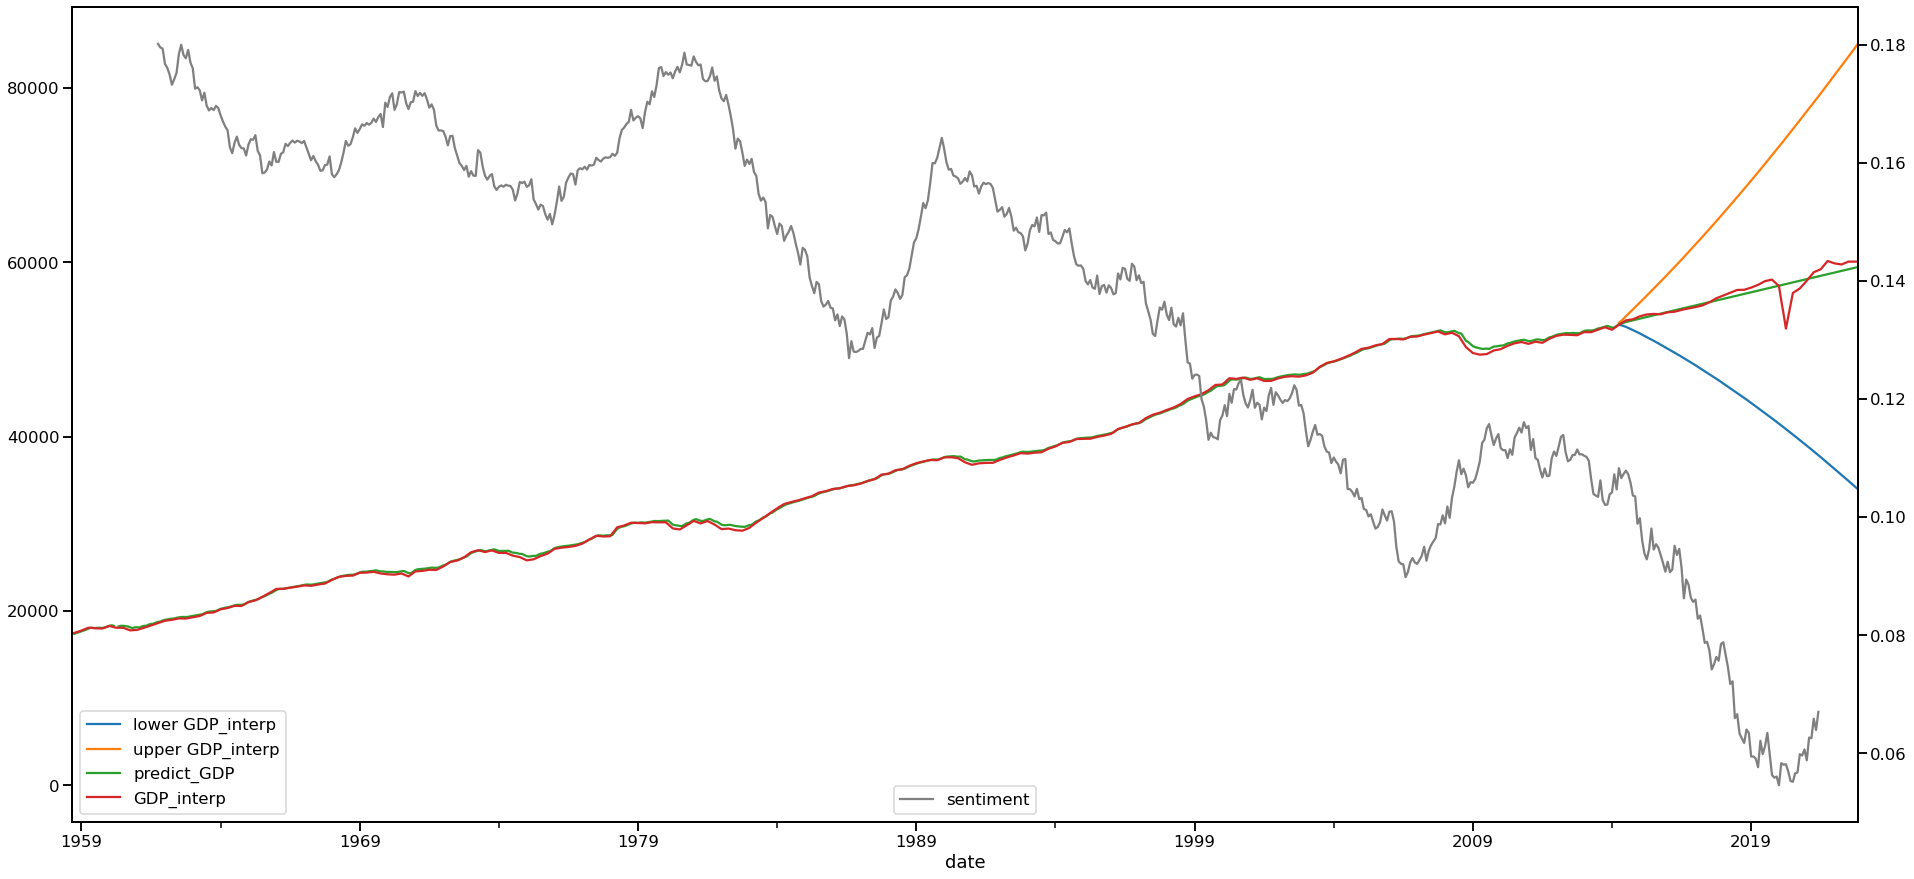

In [ ]:
from matplotlib import pyplot
sns.set_context('talk')
fig, ax1 = plt.subplots(1, 1, sharex=True,sharey=False, figsize=(32, 15))
ax2 = ax1.twinx()
ax1.fill_between(cast_df['continuous_low_GDP'],cast_df['continuous_high_GDP'])
drop_columns = ['sentiment_L19','sentiment','chart_date','continuous_low_GDP','continuous_high_GDP']
cast_df.drop(drop_columns,axis=1).plot(ax=ax1,legend=True).legend(loc='lower left')
pd.DataFrame(res_df.sentiment).shift(19).rolling(window=36,center=True).mean().plot(ax=ax2,use_index=True,legend=True,color='gray').legend(loc='lower center')


In [ ]:
y_pred_train =  predict.predicted_mean.values[:len(X_train)]
y_pred_test = predict.predicted_mean.values[len(X_train):]